In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import pickle

In [2]:
import requests
from bs4 import BeautifulSoup

In [3]:
url = "https://en.wikipedia.org/wiki/Areas_of_Chennai"

In [4]:
r = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser')
areas = soup.find('table', {'class':'wikitable'}).find_all('a')

In [6]:
import geocoder

In [7]:
chennai_df = pd.DataFrame()

In [8]:
for i,neighbor in enumerate(areas):
    print('\rProcessing: ', i+1, end="")
    record = [neighbor.text.strip()]
    record.extend(geocoder.arcgis(f'{record[0]}, Chennai, Tamil Nadu, India').latlng)
    chennai_df = chennai_df.append([record], ignore_index=True)
    
chennai_df.columns = ['Neighborhood', 'Latitude', 'Longitude']
chennai_df.drop_duplicates('Neighborhood' ,inplace=True)
chennai_df.head()

Processing:  163

,Neighborhood,Latitude,Longitude
0,Adambakkam,12.99192,80.20603
1,Adyar,13.00303,80.25187
2,Alandur,13.00013,80.20049
3,Alapakkam,13.04613,80.16501
4,Alwarpet,13.03471,80.25416


In [9]:
chennai_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 0 to 162
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neighborhood  162 non-null    object 
 1   Latitude      162 non-null    float64
 2   Longitude     162 non-null    float64
dtypes: float64(2), object(1)
memory usage: 5.1+ KB


In [10]:
from geopy.geocoders import Nominatim

import folium
from folium.plugins import HeatMap

In [11]:
address = 'Chennai, Tamil Nadu'
geolocator = Nominatim(user_agent='chennai_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chennai is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chennai is 13.035944350000001, 80.24099949725411.


In [12]:
map_chennai = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.Marker([latitude, longitude], popup='Chennai').add_to(map_chennai)

# add markers to map
for lat, lng, neighborhood in zip(chennai_df['Latitude'], chennai_df['Longitude'], chennai_df['Neighborhood']):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chennai)
    
    
map_chennai

In [13]:
LIMIT = 50
headers = {"Accept": "application/json", "Authorization": 'Your API Key'}

In [14]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = "https://api.foursquare.com/v3/places/search?&ll={},{}&limit={}".format(
            lat, 
            lng, 
            LIMIT)
            
        # make the GET request
        response = requests.get(url, headers=headers).json()['results']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['name'],
            v['geocodes']['main']['latitude'],
            v['geocodes']['main']['longitude'],
            v['categories'][0]['name'])for v in response])
            
        
#         for v in response:
#             Neighborhood = name
#             Neighborhood_Latitude = lat
#             Neighborhood_Longitude = lng
#             Venue = v['name']
#             Venue_Latitude = v['geocodes']['main']['latitude']
#             Venue_Longitude = v['geocodes']['main']['longitude']
#             Venue_Category = v['categories'][0]['name']
            
#         venues_list.append([(Neighborhood, Neighborhood_Latitude, Neighborhood_Longitude, Venue, Venue_Latitude, Venue_Longitude, Venue_Category)])



    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
chennai_venues = getNearbyVenues(names=chennai_df['Neighborhood'],
                                latitudes=chennai_df['Latitude'],
                                longitudes=chennai_df['Longitude'])
chennai_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adambakkam,12.99192,80.20603,Luxe Cinemas,12.991168,80.216830,Movie Theater
1,Adambakkam,12.99192,80.20603,Phoenix Market City,12.991893,80.217165,Business and Professional Services
2,Adambakkam,12.99192,80.20603,Imax,12.992246,80.217300,Movie Theater
3,Adambakkam,12.99192,80.20603,Mainland China,12.990986,80.217205,Chinese Restaurant
4,Adambakkam,12.99192,80.20603,Rajdhani Sports,13.090618,80.279733,Rajasthani Restaurant


In [16]:
chennai_venues.shape

(8054, 7)

In [20]:
chennai_venues.drop_duplicates(["Venue", "Venue Latitude", "Venue Longitude"], inplace=True, ignore_index=True)
chennai_venues.shape

(335, 7)

In [21]:
chennai_venues.groupby('Neighborhood').count()[['Venue']].head()

,Venue
Neighborhood,
Adambakkam,50
Adyar,26
Alandur,8
Alapakkam,24
Alwarpet,32


In [22]:
print('There are {} uniques categories.'.format(len(chennai_venues['Venue Category'].unique())))

There are 81 uniques categories.


In [23]:
chennai_venues['Venue Category'].unique()

array(['Movie Theater', 'Business and Professional Services',
       'Chinese Restaurant', 'Rajasthani Restaurant', 'Retail',
       'Belgian Restaurant', 'Bakery', 'Indian Restaurant',
       'Asian Restaurant', 'Restaurant',
       'Vegan and Vegetarian Restaurant', 'Coffee Shop', 'Bar', 'Theater',
       'North Indian Restaurant', 'Clothing Store',
       'Sports and Recreation', 'Café', 'Ice Cream Parlor',
       'Automotive Repair Shop', 'Hotel', 'Beach', 'Spa', 'Juice Bar',
       'South Indian Restaurant', 'Pizzeria', "Farmers' Market",
       'Burger Joint', 'Fast Food Restaurant', 'Bistro',
       'Italian Restaurant', 'Dining and Drinking', 'Dessert Shop',
       'Breakfast Spot', 'Department Store', 'Pub', 'Hair Salon',
       'Shopping Mall', 'Parking', 'Park', 'Pool Hall', 'Lounge',
       'Furniture and Home Store', 'Bookstore', 'African Restaurant',
       'Kerala Restaurant', 'Concert Hall', "Men's Store",
       'Swimming Pool', 'Jewelry Store', 'Cajun / Creole Restaur

In [24]:
restaurant = ['restaurant', 'bbq joint', 'snack place', 'lounge']

In [25]:
chennai_restaurant = chennai_venues[[np.any([r in x.lower() for r in restaurant]) for x in chennai_venues['Venue Category']]].reset_index(drop=True)
chennai_restaurant.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adambakkam,12.99192,80.20603,Mainland China,12.990986,80.217205,Chinese Restaurant
1,Adambakkam,12.99192,80.20603,Rajdhani Sports,13.090618,80.279733,Rajasthani Restaurant
2,Adambakkam,12.99192,80.20603,"Ottimo Cucina Italiana, ITC Grand Chola",13.010239,80.221194,Belgian Restaurant
3,Adambakkam,12.99192,80.20603,Peshawri,13.010407,80.220226,Indian Restaurant
4,Adambakkam,12.99192,80.20603,Pan Asian,13.011047,80.220306,Asian Restaurant


In [26]:
chennai_restaurant.shape

(153, 7)

In [27]:
chennai_restaurant.groupby("Venue Category").count()["Venue"].sort_values(ascending=False) / len(chennai_restaurant) * 100

Venue Category
Indian Restaurant                  31.372549
Restaurant                         20.261438
Fast Food Restaurant               13.071895
Asian Restaurant                    6.535948
Italian Restaurant                  5.228758
Chinese Restaurant                  4.575163
South Indian Restaurant             2.614379
Vegan and Vegetarian Restaurant     1.960784
North Indian Restaurant             1.307190
Hyderabadi Restaurant               1.307190
Seafood Restaurant                  1.307190
Sandwich Restaurant                 1.307190
BBQ Joint                           1.307190
Cajun / Creole Restaurant           0.653595
American Restaurant                 0.653595
Snack Place                         0.653595
Rajasthani Restaurant               0.653595
Middle Eastern Restaurant           0.653595
Bengali Restaurant                  0.653595
Lounge                              0.653595
Kerala Restaurant                   0.653595
Japanese Restaurant                 0.65

In [28]:
target_restaurant = ["Indian Restaurant", "Fast Food Restaurant", "Asian Restaurant", "Italian Restaurant", "Chinese Restaurant", "South Indian Restaurant", "Vegan and Vegetarian Restaurant"]

In [29]:
map_chennai = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.Marker([latitude, longitude], popup="Chennai city").add_to(map_chennai)

# add markers to map
for lat, lng, category in zip(chennai_restaurant['Neighborhood Latitude'], chennai_restaurant['Neighborhood Longitude'], chennai_restaurant['Venue Category']):
    label = folium.Popup(category, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue' if category == "Indian Restaurant" else "red",
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_chennai)  
    
map_chennai

In [30]:
map_chennai = folium.Map([lat, lng], zoom_start=11)
folium.Marker([latitude, longitude], popup="Chennai city").add_to(map_chennai)

HeatMap(chennai_restaurant[["Venue Latitude", "Venue Longitude"]].to_numpy()).add_to(map_chennai)

map_chennai

In [31]:
chennai_onehot = pd.get_dummies(chennai_venues[['Venue Category']], prefix="", prefix_sep="")
chennai_onehot['Neighborhood'] = chennai_venues['Neighborhood']
fixed_columns = ['Neighborhood'] + list(chennai_onehot.columns.drop('Neighborhood'))
chennai_onehot = chennai_onehot[fixed_columns]

chennai_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Art Museum,Arts and Entertainment,Asian Restaurant,Automotive Repair Shop,Automotive Retail,BBQ Joint,...,Spa,Sporting Goods Retail,Sports and Recreation,Stadium,Swimming Pool,Tattoo Parlor,Theater,Vegan and Vegetarian Restaurant,Video Store,Zoo
0,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
chennai_onehot.shape

(335, 82)

In [33]:
chennai_density = chennai_onehot.groupby('Neighborhood').mean().reset_index()
chennai_density.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Art Museum,Arts and Entertainment,Asian Restaurant,Automotive Repair Shop,Automotive Retail,BBQ Joint,...,Spa,Sporting Goods Retail,Sports and Recreation,Stadium,Swimming Pool,Tattoo Parlor,Theater,Vegan and Vegetarian Restaurant,Video Store,Zoo
0,Adambakkam,0.0,0.00000,0.0,0.0,0.0,0.040000,0.02,0.0,0.0,...,0.02,0.0,0.02,0.0,0.00000,0.0,0.02,0.02,0.0,0.0
1,Adyar,0.0,0.00000,0.0,0.0,0.0,0.076923,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00000,0.0,0.00,0.00,0.0,0.0
2,Alandur,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00000,0.0,0.00,0.00,0.0,0.0
3,Alapakkam,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00000,0.0,0.00,0.00,0.0,0.0
4,Alwarpet,0.0,0.03125,0.0,0.0,0.0,0.093750,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.03125,0.0,0.00,0.00,0.0,0.0


In [34]:
chennai_density.shape

(31, 82)

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chennai_density['Neighborhood']

for ind in np.arange(chennai_density.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_density.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,Indian Restaurant,Restaurant,Beach,Retail,Bakery,Movie Theater,Asian Restaurant,Chinese Restaurant,Ice Cream Parlor,Hotel
1,Adyar,Indian Restaurant,Bakery,Asian Restaurant,Beach,Dessert Shop,Chinese Restaurant,Juice Bar,Italian Restaurant,Ice Cream Parlor,Hair Salon
2,Alandur,Retail,Indian Restaurant,Parking,Shopping Mall,Bakery,Fast Food Restaurant,Movie Theater,Pizzeria,Park,North Indian Restaurant
3,Alapakkam,Ice Cream Parlor,Fast Food Restaurant,Restaurant,Italian Restaurant,Indian Restaurant,Shopping Mall,Lounge,Park,Pool Hall,Pub
4,Alwarpet,Indian Restaurant,Asian Restaurant,Movie Theater,Bakery,Restaurant,Burger Joint,Bookstore,Fast Food Restaurant,Department Store,Furniture and Home Store


In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [39]:
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chennai_density.drop("Neighborhood", 1))
np.unique(kmeans.labels_, return_counts=True)

C:\Users\Anurag\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


(array([0, 1, 2, 3]), array([ 5,  1, 24,  1], dtype=int64))

In [40]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [41]:
chennai_merged = chennai_df.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='inner').reset_index(drop=True)

chennai_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,12.99192,80.20603,2,Indian Restaurant,Restaurant,Beach,Retail,Bakery,Movie Theater,Asian Restaurant,Chinese Restaurant,Ice Cream Parlor,Hotel
1,Adyar,13.00303,80.25187,2,Indian Restaurant,Bakery,Asian Restaurant,Beach,Dessert Shop,Chinese Restaurant,Juice Bar,Italian Restaurant,Ice Cream Parlor,Hair Salon
2,Alandur,13.00013,80.20049,2,Retail,Indian Restaurant,Parking,Shopping Mall,Bakery,Fast Food Restaurant,Movie Theater,Pizzeria,Park,North Indian Restaurant
3,Alapakkam,13.04613,80.16501,2,Ice Cream Parlor,Fast Food Restaurant,Restaurant,Italian Restaurant,Indian Restaurant,Shopping Mall,Lounge,Park,Pool Hall,Pub
4,Alwarpet,13.03471,80.25416,2,Indian Restaurant,Asian Restaurant,Movie Theater,Bakery,Restaurant,Burger Joint,Bookstore,Fast Food Restaurant,Department Store,Furniture and Home Store


In [42]:
chennai_density = chennai_df.join(chennai_density.set_index('Neighborhood'), on='Neighborhood', how='inner').reset_index(drop=True)
chennai_density.insert(3, 'Cluster Labels', kmeans.labels_)

chennai_density.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,Afghan Restaurant,African Restaurant,American Restaurant,Art Museum,Arts and Entertainment,Asian Restaurant,...,Spa,Sporting Goods Retail,Sports and Recreation,Stadium,Swimming Pool,Tattoo Parlor,Theater,Vegan and Vegetarian Restaurant,Video Store,Zoo
0,Adambakkam,12.99192,80.20603,2,0.0,0.00000,0.0,0.0,0.0,0.040000,...,0.02,0.0,0.02,0.0,0.00000,0.0,0.02,0.02,0.0,0.0
1,Adyar,13.00303,80.25187,2,0.0,0.00000,0.0,0.0,0.0,0.076923,...,0.00,0.0,0.00,0.0,0.00000,0.0,0.00,0.00,0.0,0.0
2,Alandur,13.00013,80.20049,2,0.0,0.00000,0.0,0.0,0.0,0.000000,...,0.00,0.0,0.00,0.0,0.00000,0.0,0.00,0.00,0.0,0.0
3,Alapakkam,13.04613,80.16501,2,0.0,0.00000,0.0,0.0,0.0,0.000000,...,0.00,0.0,0.00,0.0,0.00000,0.0,0.00,0.00,0.0,0.0
4,Alwarpet,13.03471,80.25416,2,0.0,0.03125,0.0,0.0,0.0,0.093750,...,0.00,0.0,0.00,0.0,0.03125,0.0,0.00,0.00,0.0,0.0


In [43]:
chennai_restaurant_density = chennai_density[['Neighborhood', 'Latitude', 'Longitude', 'Cluster Labels']+ list(chennai_restaurant['Venue Category'].unique())]

chennai_restaurant_density.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,Chinese Restaurant,Rajasthani Restaurant,Belgian Restaurant,Indian Restaurant,Asian Restaurant,Restaurant,...,Middle Eastern Restaurant,Snack Place,Seafood Restaurant,Sandwich Restaurant,Hyderabadi Restaurant,Japanese Restaurant,BBQ Joint,Afghan Restaurant,Bengali Restaurant,American Restaurant
0,Adambakkam,12.99192,80.20603,2,0.040000,0.02,0.02,0.180000,0.040000,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Adyar,13.00303,80.25187,2,0.038462,0.00,0.00,0.115385,0.076923,0.038462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alandur,13.00013,80.20049,2,0.000000,0.00,0.00,0.125000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alapakkam,13.04613,80.16501,2,0.041667,0.00,0.00,0.041667,0.000000,0.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alwarpet,13.03471,80.25416,2,0.000000,0.00,0.00,0.125000,0.093750,0.093750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color for the clusters
color = ["red", "green", "blue", "darkgoldenrod"]

# add markers to the map
folium.Marker([latitude, longitude], popup="Chennai city").add_to(map_clusters)
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Latitude'], chennai_merged['Longitude'], chennai_merged['Neighborhood'], chennai_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=color[cluster],
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)

# Add Categorical Legend
legend_html = """
<div style="position:fixed;
    background: white;
    top: 10px; 
    right: 10px; 
    width: 100px; 
    height: 85px; 
    border:2px solid grey; 
    z-index: 9999;
    font-size:14px;">
    &nbsp;<i class="fa fa-circle fa-1x" style="color:{}"></i>&nbsp;Cluster 0<br>
    &nbsp;<i class="fa fa-circle fa-1x" style="color:{}"></i>&nbsp;Cluster 1<br>
    &nbsp;<i class="fa fa-circle fa-1x" style="color:{}"></i>&nbsp;Cluster 2<br>
    &nbsp;<i class="fa fa-circle fa-1x" style="color:{}"></i>&nbsp;Cluster 3
</div>""".format(*color)
map_clusters.get_root().html.add_child(folium.Element(legend_html))
       
map_clusters

In [45]:
cluster0 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 0].drop(['Latitude', 'Longitude', 'Cluster Labels'], 1).reset_index(drop=True)
cluster0

C:\Users\Anurag\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alwarthirunagar,Indian Restaurant,Jewelry Store,Park,Language School,Cajun / Creole Restaurant,Music Venue,Pool Hall,Pizzeria,Parking,North Indian Restaurant
1,K.K. Nagar,Indian Restaurant,Restaurant,Pub,Pizzeria,Parking,Park,North Indian Restaurant,Night Club,Music Venue,Movie Theater
2,Korattur,Indian Restaurant,Race Track,Video Store,Middle Eastern Restaurant,Pizzeria,Parking,Park,North Indian Restaurant,Night Club,Music Venue
3,Manali New Town,Indian Restaurant,Indie Movie Theater,Pool Hall,Pizzeria,Parking,Park,North Indian Restaurant,Night Club,Music Venue,Movie Theater
4,Royapettah,Indian Restaurant,Indie Movie Theater,Pool Hall,Pizzeria,Parking,Park,North Indian Restaurant,Night Club,Music Venue,Movie Theater


In [46]:
Counter(cluster0.to_numpy().flatten()).most_common(10)

[('Indian Restaurant', 5),
 ('Park', 5),
 ('Music Venue', 5),
 ('Pizzeria', 5),
 ('Parking', 5),
 ('North Indian Restaurant', 5),
 ('Night Club', 4),
 ('Pool Hall', 3),
 ('Movie Theater', 3),
 ('Indie Movie Theater', 2)]

In [47]:
cluster0_restaurant = chennai_restaurant_density.loc[chennai_restaurant_density['Cluster Labels'] == 0].drop(['Latitude', 'Longitude', 'Cluster Labels'], 1).reset_index(drop=True)
cluster0_restaurant.insert(1, 'Restaurant fraction', cluster0_restaurant.sum(axis=1))

cluster0_restaurant

C:\Users\Anurag\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
C:\Users\Anurag\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


,Neighborhood,Restaurant fraction,Chinese Restaurant,Rajasthani Restaurant,Belgian Restaurant,Indian Restaurant,Asian Restaurant,Restaurant,Vegan and Vegetarian Restaurant,North Indian Restaurant,...,Middle Eastern Restaurant,Snack Place,Seafood Restaurant,Sandwich Restaurant,Hyderabadi Restaurant,Japanese Restaurant,BBQ Joint,Afghan Restaurant,Bengali Restaurant,American Restaurant
0,Alwarthirunagar,0.571429,0.0,0.0,0.0,0.428571,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,Kazhipattur,0.611111,0.0,0.0,0.0,0.111111,0.0,0.166667,0.0,0.055556,...,0.0,0.0,0.055556,0.0,0.0,0.0,0.055556,0.0,0.0,0.0
2,Korattur,0.500000,0.0,0.0,0.0,0.500000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,Manali New Town,1.000000,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,Royapettah,1.000000,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [48]:
cluster0_restaurant[['Neighborhood', 'Restaurant fraction'] + target_restaurant]

,Neighborhood,Restaurant fraction,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Italian Restaurant,Chinese Restaurant,South Indian Restaurant,Vegan and Vegetarian Restaurant
0,Alwarthirunagar,0.571429,0.428571,0.000000,0.0,0.000000,0.0,0.0,0.0
1,Kazhipattur,0.611111,0.111111,0.111111,0.0,0.055556,0.0,0.0,0.0
2,Korattur,0.500000,0.500000,0.000000,0.0,0.000000,0.0,0.0,0.0
3,Manali New Town,1.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
4,Royapettah,1.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0


In [49]:
cluster0_restaurant[target_restaurant].mean()

Indian Restaurant                  0.607937
Fast Food Restaurant               0.022222
Asian Restaurant                   0.000000
Italian Restaurant                 0.011111
Chinese Restaurant                 0.000000
South Indian Restaurant            0.000000
Vegan and Vegetarian Restaurant    0.000000
dtype: float64

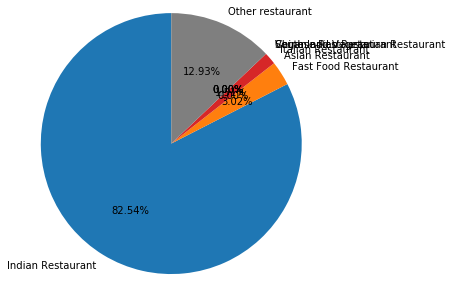

In [56]:
x = np.append(cluster0_restaurant[target_restaurant].sum().values, cluster0_restaurant['Restaurant fraction'].sum()-cluster0_restaurant[target_restaurant].sum().sum())
labels = np.append(cluster0_restaurant[target_restaurant].sum().index, 'Other restaurant')
plt.pie(x=x, labels=labels, radius=1.5, startangle=90, autopct="%.2f%%");

In [57]:
cluster1 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 1].drop(['Latitude', 'Longitude', 'Cluster Labels'], 1).reset_index(drop=True)
cluster1

C:\Users\Anurag\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Choolaimedu,Parking,Afghan Restaurant,Indie Movie Theater,Pool Hall,Pizzeria,Park,North Indian Restaurant,Night Club,Music Venue,Movie Theater


In [58]:
cluster1_restaurant = chennai_restaurant_density.loc[chennai_restaurant_density['Cluster Labels'] == 1].drop(['Latitude', 'Longitude', 'Cluster Labels'], 1).reset_index(drop=True)
cluster1_restaurant.insert(1, 'Restaurant fraction', cluster1_restaurant.sum(axis=1))

cluster1_restaurant

C:\Users\Anurag\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
C:\Users\Anurag\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


,Neighborhood,Restaurant fraction,Chinese Restaurant,Rajasthani Restaurant,Belgian Restaurant,Indian Restaurant,Asian Restaurant,Restaurant,Vegan and Vegetarian Restaurant,North Indian Restaurant,...,Middle Eastern Restaurant,Snack Place,Seafood Restaurant,Sandwich Restaurant,Hyderabadi Restaurant,Japanese Restaurant,BBQ Joint,Afghan Restaurant,Bengali Restaurant,American Restaurant
0,Choolaimedu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
cluster1_restaurant[['Neighborhood', 'Restaurant fraction'] + target_restaurant]

,Neighborhood,Restaurant fraction,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Italian Restaurant,Chinese Restaurant,South Indian Restaurant,Vegan and Vegetarian Restaurant
0,Choolaimedu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
cluster1_restaurant[target_restaurant].mean()

Indian Restaurant                  0.0
Fast Food Restaurant               0.0
Asian Restaurant                   0.0
Italian Restaurant                 0.0
Chinese Restaurant                 0.0
South Indian Restaurant            0.0
Vegan and Vegetarian Restaurant    0.0
dtype: float64

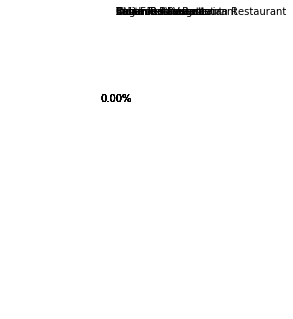

In [62]:
x = np.append(cluster1_restaurant[target_restaurant].sum().values, cluster1_restaurant['Restaurant fraction'].sum()-cluster1_restaurant[target_restaurant].sum().sum())*100
labels = np.append(cluster1_restaurant[target_restaurant].sum().index, 'Other restaurant')
plt.pie(x=x, labels=labels, radius=2, startangle=90, autopct="%.2f%%");

In [63]:
cluster2 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 2].drop(['Latitude', 'Longitude', 'Cluster Labels'], 1).reset_index(drop=True)
cluster2

C:\Users\Anurag\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,Indian Restaurant,Restaurant,Beach,Retail,Bakery,Movie Theater,Asian Restaurant,Chinese Restaurant,Ice Cream Parlor,Hotel
1,Adyar,Indian Restaurant,Bakery,Asian Restaurant,Beach,Dessert Shop,Chinese Restaurant,Juice Bar,Italian Restaurant,Ice Cream Parlor,Hair Salon
2,Alandur,Retail,Indian Restaurant,Parking,Shopping Mall,Bakery,Fast Food Restaurant,Movie Theater,Pizzeria,Park,North Indian Restaurant
3,Alapakkam,Ice Cream Parlor,Fast Food Restaurant,Restaurant,Italian Restaurant,Indian Restaurant,Shopping Mall,Lounge,Park,Pool Hall,Pub
4,Alwarpet,Indian Restaurant,Asian Restaurant,Movie Theater,Bakery,Restaurant,Burger Joint,Bookstore,Fast Food Restaurant,Department Store,Furniture and Home Store
5,Ambattur,Restaurant,Indian Restaurant,Bakery,Chinese Restaurant,Retail,Burger Joint,Dining and Drinking,Snack Place,Music Venue,Fast Food Restaurant
6,Aminjikarai,Italian Restaurant,Bakery,Ice Cream Parlor,Tattoo Parlor,Restaurant,Stadium,Night Club,Fast Food Restaurant,Afghan Restaurant,Middle Eastern Restaurant
7,Ashok Nagar,Indian Restaurant,Ice Cream Parlor,Bakery,Clothing Store,Vegan and Vegetarian Restaurant,Jewelry Store,Music Venue,Pool Hall,Pizzeria,Parking
8,Avadi,Retail,Afghan Restaurant,Pub,Pizzeria,Parking,Park,North Indian Restaurant,Night Club,Music Venue,Movie Theater
9,Ayanavaram,Restaurant,Italian Restaurant,Pizzeria,Seafood Restaurant,Bakery,Movie Theater,Parking,Park,North Indian Restaurant,Night Club


In [64]:
Counter(cluster2.to_numpy().flatten()).most_common(10)

[('Movie Theater', 15),
 ('Indian Restaurant', 14),
 ('Pizzeria', 14),
 ('Parking', 13),
 ('Restaurant', 12),
 ('Park', 12),
 ('North Indian Restaurant', 12),
 ('Bakery', 10),
 ('Night Club', 9),
 ('Fast Food Restaurant', 8)]

In [65]:
cluster2_restaurant = chennai_restaurant_density.loc[chennai_restaurant_density['Cluster Labels'] == 2].drop(['Latitude', 'Longitude', 'Cluster Labels'], 1).reset_index(drop=True)
cluster2_restaurant.insert(1, 'Restaurant fraction', cluster2_restaurant.sum(axis=1))

cluster2_restaurant

C:\Users\Anurag\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
C:\Users\Anurag\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


,Neighborhood,Restaurant fraction,Chinese Restaurant,Rajasthani Restaurant,Belgian Restaurant,Indian Restaurant,Asian Restaurant,Restaurant,Vegan and Vegetarian Restaurant,North Indian Restaurant,...,Middle Eastern Restaurant,Snack Place,Seafood Restaurant,Sandwich Restaurant,Hyderabadi Restaurant,Japanese Restaurant,BBQ Joint,Afghan Restaurant,Bengali Restaurant,American Restaurant
0,Adambakkam,0.460000,0.040000,0.02,0.02,0.180000,0.040000,0.100000,0.020000,0.02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Adyar,0.346154,0.038462,0.00,0.00,0.115385,0.076923,0.038462,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Alandur,0.250000,0.000000,0.00,0.00,0.125000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Alapakkam,0.500000,0.041667,0.00,0.00,0.041667,0.000000,0.125000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Alwarpet,0.406250,0.000000,0.00,0.00,0.125000,0.093750,0.093750,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Ambattur,0.538462,0.076923,0.00,0.00,0.076923,0.000000,0.153846,0.000000,0.00,...,0.076923,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Aminjikarai,0.400000,0.000000,0.00,0.00,0.000000,0.000000,0.100000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Ashok Nagar,0.333333,0.000000,0.00,0.00,0.166667,0.000000,0.000000,0.166667,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Avadi,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Ayanavaram,0.666667,0.000000,0.00,0.00,0.000000,0.000000,0.333333,0.000000,0.00,...,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [66]:
cluster2_restaurant[['Neighborhood', 'Restaurant fraction'] + target_restaurant]

,Neighborhood,Restaurant fraction,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Italian Restaurant,Chinese Restaurant,South Indian Restaurant,Vegan and Vegetarian Restaurant
0,Adambakkam,0.460000,0.180000,0.000000,0.040000,0.000000,0.040000,0.020000,0.020000
1,Adyar,0.346154,0.115385,0.038462,0.076923,0.038462,0.038462,0.000000,0.000000
2,Alandur,0.250000,0.125000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Alapakkam,0.500000,0.041667,0.125000,0.000000,0.083333,0.041667,0.041667,0.000000
4,Alwarpet,0.406250,0.125000,0.031250,0.093750,0.000000,0.000000,0.000000,0.000000
5,Ambattur,0.538462,0.076923,0.076923,0.000000,0.000000,0.076923,0.000000,0.000000
6,Aminjikarai,0.400000,0.000000,0.100000,0.000000,0.200000,0.000000,0.000000,0.000000
7,Ashok Nagar,0.333333,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667
8,Avadi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Ayanavaram,0.666667,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000


In [67]:
cluster2_restaurant[target_restaurant].mean()

Indian Restaurant                  0.097380
Fast Food Restaurant               0.031283
Asian Restaurant                   0.065202
Italian Restaurant                 0.023130
Chinese Restaurant                 0.056822
South Indian Restaurant            0.005347
Vegan and Vegetarian Restaurant    0.018194
dtype: float64

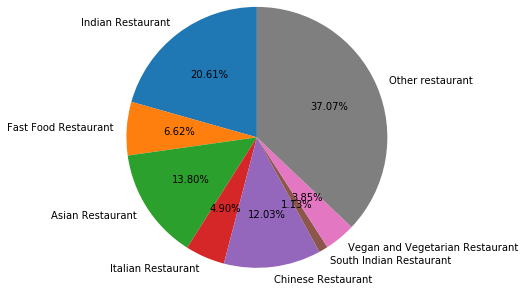

In [68]:
x = np.append(cluster2_restaurant[target_restaurant].sum().values, cluster2_restaurant['Restaurant fraction'].sum()-cluster2_restaurant[target_restaurant].sum().sum())*100
labels = np.append(cluster2_restaurant[target_restaurant].sum().index, 'Other restaurant')
plt.pie(x=x, labels=labels, radius=1.5, startangle=90, autopct="%.2f%%");

In [69]:
cluster3 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 3].drop(['Latitude', 'Longitude', 'Cluster Labels'], 1).reset_index(drop=True)
cluster3

C:\Users\Anurag\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Annanur,South Indian Restaurant,Afghan Restaurant,Pub,Pizzeria,Parking,Park,North Indian Restaurant,Night Club,Music Venue,Movie Theater


In [70]:
Counter(cluster3.to_numpy().flatten()).most_common(10)

[('Annanur', 1),
 ('South Indian Restaurant', 1),
 ('Afghan Restaurant', 1),
 ('Pub', 1),
 ('Pizzeria', 1),
 ('Parking', 1),
 ('Park', 1),
 ('North Indian Restaurant', 1),
 ('Night Club', 1),
 ('Music Venue', 1)]

In [71]:
cluster3_restaurant = chennai_restaurant_density.loc[chennai_restaurant_density['Cluster Labels'] == 3].drop(['Latitude', 'Longitude', 'Cluster Labels'], 1).reset_index(drop=True)
cluster3_restaurant.insert(1, 'Restaurant fraction', cluster3_restaurant.sum(axis=1))

cluster3_restaurant

C:\Users\Anurag\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
C:\Users\Anurag\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


,Neighborhood,Restaurant fraction,Chinese Restaurant,Rajasthani Restaurant,Belgian Restaurant,Indian Restaurant,Asian Restaurant,Restaurant,Vegan and Vegetarian Restaurant,North Indian Restaurant,...,Middle Eastern Restaurant,Snack Place,Seafood Restaurant,Sandwich Restaurant,Hyderabadi Restaurant,Japanese Restaurant,BBQ Joint,Afghan Restaurant,Bengali Restaurant,American Restaurant
0,Annanur,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
cluster3_restaurant[['Neighborhood', 'Restaurant fraction'] + target_restaurant]

,Neighborhood,Restaurant fraction,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Italian Restaurant,Chinese Restaurant,South Indian Restaurant,Vegan and Vegetarian Restaurant
0,Annanur,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [73]:
cluster3_restaurant[cluster3_restaurant['Restaurant fraction'] <= .2][['Neighborhood', 'Restaurant fraction'] + target_restaurant]

,Neighborhood,Restaurant fraction,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Italian Restaurant,Chinese Restaurant,South Indian Restaurant,Vegan and Vegetarian Restaurant


In [74]:
cluster3_restaurant[target_restaurant].mean()


Indian Restaurant                  0.0
Fast Food Restaurant               0.0
Asian Restaurant                   0.0
Italian Restaurant                 0.0
Chinese Restaurant                 0.0
South Indian Restaurant            1.0
Vegan and Vegetarian Restaurant    0.0
dtype: float64

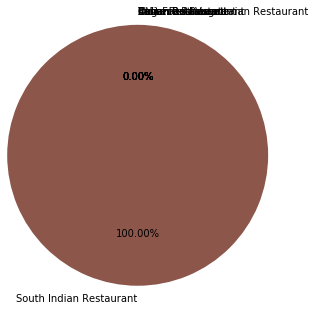

In [75]:
x = np.append(cluster3_restaurant[target_restaurant].sum().values, cluster3_restaurant['Restaurant fraction'].sum()-cluster3_restaurant[target_restaurant].sum().sum())
labels = np.append(cluster3_restaurant[target_restaurant].sum().index, 'Other restaurant')
plt.pie(x=x, labels=labels, radius=1.5, startangle=90, autopct="%.2f%%");